# 鸢尾花分类

### 反向传播算法、随机梯度下降法

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
# -- 鸢尾花数据的读入 --
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)  # 样本数量

In [3]:
# -- 对输入数据进行标准化处理 --
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

In [4]:
# -- 将正确答案转换为独热编码格式 --
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

In [9]:
# -- 训练数据与测试数据 --
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]
#print(index_train)
input_train = input_data[index_train, :]  # 训练 输入
#print(input_train)
correct_train = correct_data[index_train, :]  # 训练 正确答案
#print(correct_train)
input_test = input_data[index_test, :]  # 测试 输入
correct_test = correct_data[index_test, :]  # 测试 正确答案

n_train = input_train.shape[0]  # 训练数据的样本数
n_test = input_test.shape[0]  # 测试数据的样本数



In [6]:
# -- 各种设置值 --
n_in = 4  # 输入层的神经元数量
n_mid = 25  # 中间层的神经元数量
n_out = 3  # 输出层的神经元数量

wb_width = 0.1  # 权重和偏置的分散度
eta = 0.01  # 学习系数
epoch = 1000
batch_size = 8
interval = 100  # 显示进度的时间间隔

In [7]:
# -- 各个网络层的祖先类 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)  # 权重（矩阵）
        self.b = wb_width * np.random.randn(n)  # 偏置（向量）

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- 中间层 --
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)  # ReLU的微分

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)        
        self.grad_x = np.dot(delta, self.w.T)        # 反向传播

# -- 输出层 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)  # SoftMax函数

    def backward(self, t):
        delta = self.y - t        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)        
        self.grad_x = np.dot(delta, self.w.T)          # 反向传播

In [8]:
# -- 各个网络层的初始化 --
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# -- 正向传播 ，一层一层的传播--
def forward_propagation(x):
    middle_layer_1.forward(x)
    middle_layer_2.forward(middle_layer_1.y)
    output_layer.forward(middle_layer_2.y)

# -- 逆向传播，一层一层传播 --
def backpropagation(t):
    output_layer.backward(t)
    middle_layer_2.backward(output_layer.grad_x)
    middle_layer_1.backward(middle_layer_2.grad_x)



In [9]:
# -- 权重和偏置的更新 --
def uppdate_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

# -- 计算误差 --
def get_error(t, batch_size):
    return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size  # 交叉熵误差


# -- 用于记录误差 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

In [10]:
# -- 记录学习的过程和经过 --
n_batch = n_train // batch_size  # 每一轮epoch的批次尺寸
for i in range(epoch):

    # -- 误差的统计和测算 --  
    forward_propagation(input_train)    #调用forward_propagation函数
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test)
    error_test = get_error(correct_test, n_test)
    
    # -- 误差的记录 -- 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    
    # -- 进度的显示 -- 
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))

    # -- 学习 -- 
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)  # 将索引值随机的打乱排序
    for j in range(n_batch):
        
        # 取出最小批次
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        # 正向传播和反向传播
        forward_propagation(x)
        backpropagation(t)
        
        # 权重和偏置的更新
        uppdate_wb()
    


Epoch:0/1000 Error_train:1.1149085043774865 Error_test:1.1133540837394966
Epoch:100/1000 Error_train:0.020822294569524034 Error_test:0.07066384504202698
Epoch:200/1000 Error_train:0.00702295015775374 Error_test:0.08454749431130609
Epoch:300/1000 Error_train:0.0027232691793762634 Error_test:0.09616155412402197
Epoch:400/1000 Error_train:0.0015625497655185636 Error_test:0.10716032697686712
Epoch:500/1000 Error_train:0.0010329640127478034 Error_test:0.11669528593196281
Epoch:600/1000 Error_train:0.0007569350021957991 Error_test:0.12607867639827017
Epoch:700/1000 Error_train:0.0005819914953107497 Error_test:0.13291037943883574
Epoch:800/1000 Error_train:0.0004703688734369031 Error_test:0.1402723422170035
Epoch:900/1000 Error_train:0.000392179061987718 Error_test:0.1467129981800132


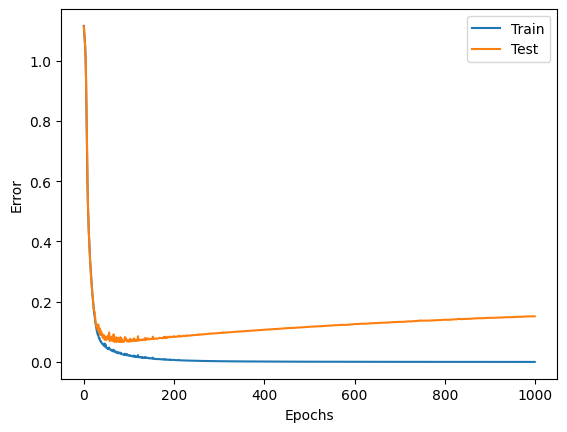

Accuracy Train: 100.0% Accuracy Test: 92.0%


In [11]:
# -- 用图表表示误差的记录 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 测算正确率 -- 
forward_propagation(input_train)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_train, axis=1))

forward_propagation(input_test)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_test, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")